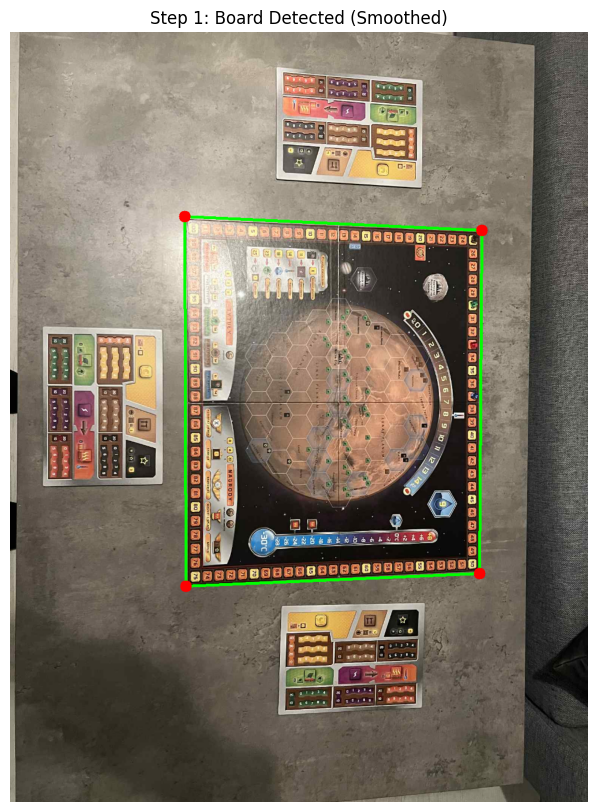

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_inline(img_bgr, title="Image"):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def detect_board_tweaked(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not find {image_path}")
        return None, None

    # Resize
    height, width = img.shape[:2]
    target_width = 1000
    scale = target_width / width
    dim = (target_width, int(height * scale))
    img_resized = cv2.resize(img, dim)

    # Process
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # TWEAK 1: Bilateral Filter instead of Gaussian
    # This blurs the floor noise heavily but keeps the board edge sharp
    blur = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Canny (Your preferred settings)
    edged = cv2.Canny(blur, 30, 100)
    
    # Dilation
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edged, kernel, iterations=2)

    # Find Contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    board_contour = None
    for c in contours[:5]:
        
        # TWEAK 2: Convex Hull
        # This acts like a rubber band, snapping tight over any 'squiggles' or cracks
        hull = cv2.convexHull(c)
        
        peri = cv2.arcLength(hull, True)
        
        # TWEAK 3: Increased Epsilon (0.02 -> 0.04)
        # This makes the polygon 'stiffer'. It refuses to bend for small deviations.
        approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
        
        if len(approx) == 4 and cv2.contourArea(hull) > 50000:
            board_contour = approx
            break

    if board_contour is not None:
        debug_img = img_resized.copy()
        cv2.drawContours(debug_img, [board_contour], -1, (0, 255, 0), 4)
        
        # Visual Check: Draw dots on the 4 corners found
        for p in board_contour:
            cv2.circle(debug_img, tuple(p[0]), 10, (0, 0, 255), -1)
            
        show_inline(debug_img, "Step 1: Board Detected (Smoothed)")
        return img_resized, board_contour
    else:
        print("Failed to detect board.")
        show_inline(dilated, "Debug: Failed Edges")
        return img_resized, None

# Run detection
img_result, contour_result = detect_board_tweaked("mp2.jpg")

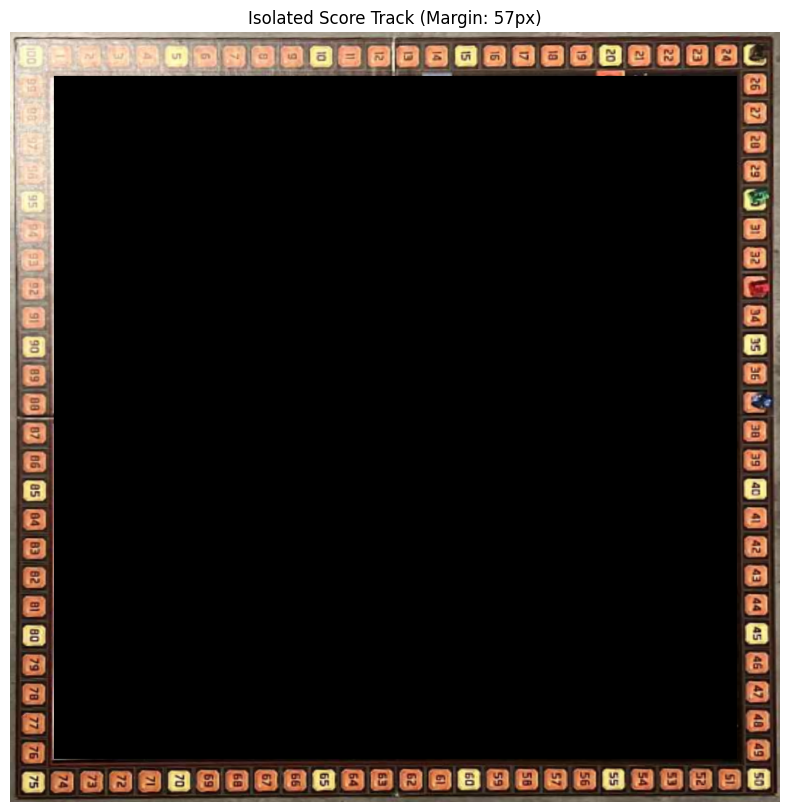

In [4]:
def isolate_score_track(img, board_contour):

    if img is None or board_contour is None:

        print("Missing input data. Run the previous cell first.")

        return


    # --- 1. Perspective Transform (Flatten the Board) ---

    # Helper to order points: top-left, top-right, bottom-right, bottom-left

    def order_points(pts):

        rect = np.zeros((4, 2), dtype="float32")

        s = pts.sum(axis=1)

        rect[0] = pts[np.argmin(s)] # TL

        rect[2] = pts[np.argmax(s)] # BR

        diff = np.diff(pts, axis=1)

        rect[1] = pts[np.argmin(diff)] # TR

        rect[3] = pts[np.argmax(diff)] # BL

        return rect


    # Get the 4 corners from your detection

    rect = order_points(board_contour.reshape(4, 2))

   

    # Define a standard size for the flat board (e.g., 1000x1000 pixels)

    # This makes calculations easy regardless of the original image size

    warped_size = 1000

    dst = np.array([

        [0, 0],

        [warped_size - 1, 0],

        [warped_size - 1, warped_size - 1],

        [0, warped_size - 1]], dtype="float32")

   

    # Compute the Matrix and Warp

    M = cv2.getPerspectiveTransform(rect, dst)

    warped = cv2.warpPerspective(img, M, (warped_size, warped_size))

   

    # --- 2. Calculate the Rim Mask (Using 48/52 Ratio) ---

    # Ratio of Inner Map to Total Board = 48/52

    inner_ratio = 46 / 52

   

    # Calculate the margin thickness (The track width)

    # Total margin is (1 - inner_ratio), so one side is half of that

    margin_percentage = (1.0 - inner_ratio) / 2.0

   

    margin_px = int(warped_size * margin_percentage)

   

    # Create the mask

    mask = np.zeros((warped_size, warped_size), dtype="uint8")

   

    # White Box = The Whole Board

    cv2.rectangle(mask, (0, 0), (warped_size, warped_size), 255, -1)

   

    # Black Box = The Inner Map (Erase the center)

    # Start at 'margin_px', End at 'size - margin_px'

    cv2.rectangle(mask,

                  (margin_px, margin_px),

                  (warped_size - margin_px, warped_size - margin_px),

                  0, -1)

   

    # Apply Mask

    track_only = cv2.bitwise_and(warped, warped, mask=mask)

   

    # --- 3. Visualization ---

    show_inline(track_only, f"Isolated Score Track (Margin: {margin_px}px)")

   

    return track_only,warped


# EXECUTE

# Ensure img_result and contour_result exist from your previous cell

score_track_img,map = isolate_score_track(img_result, contour_result) 

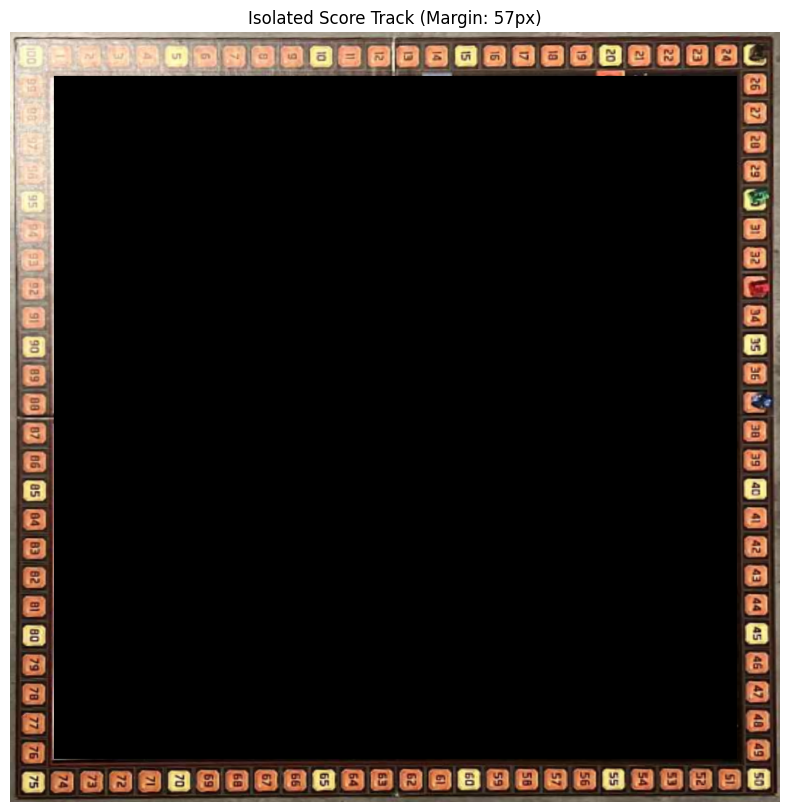

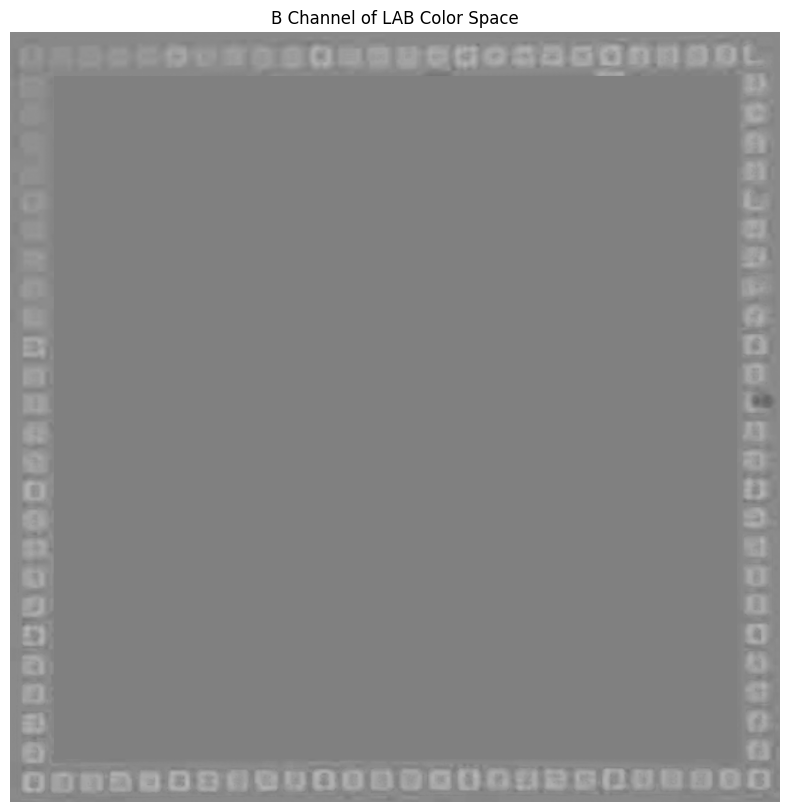

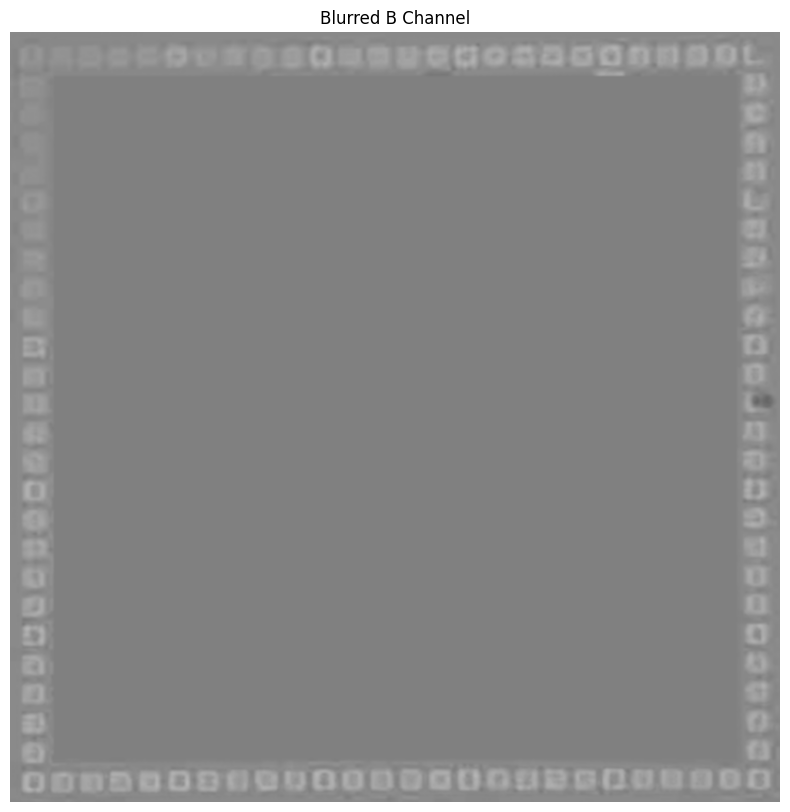

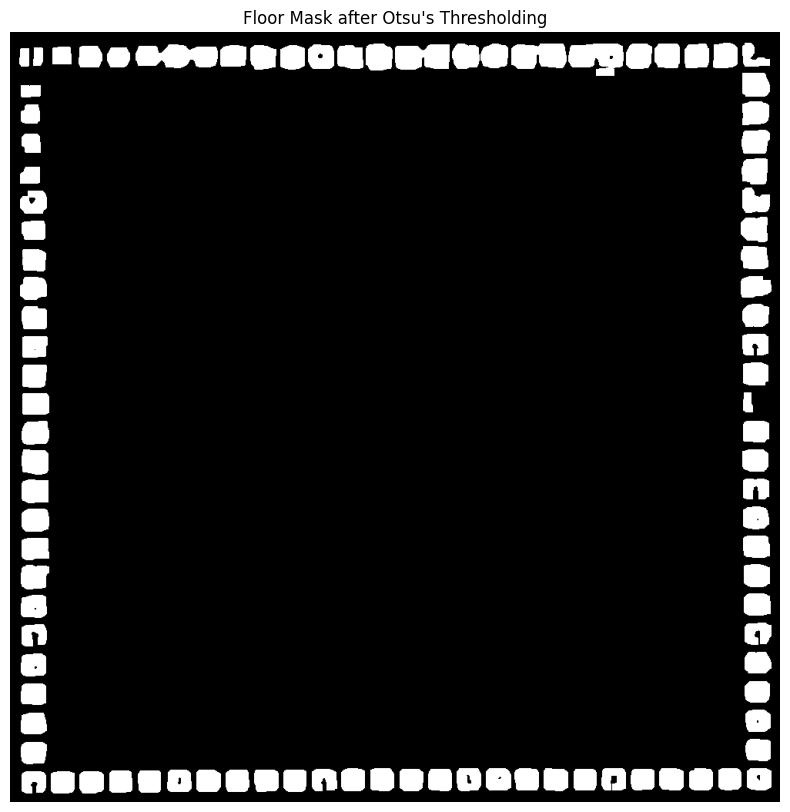

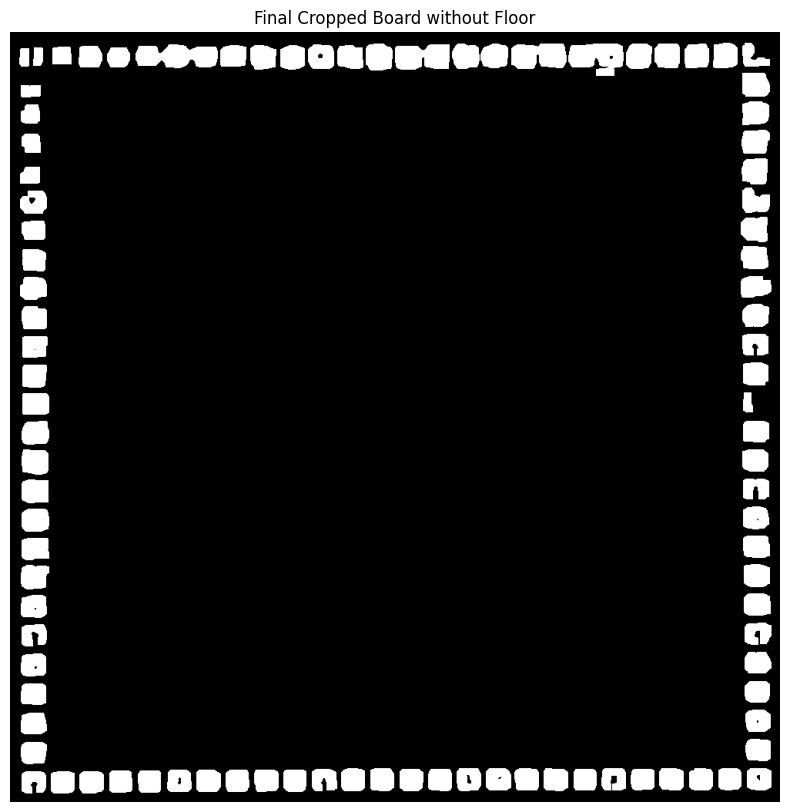

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt # Using plt for better inline visualization

def crop_floor_by_lab(image):
    if image is None: return None
    
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    b_channel = lab[:, :, 2] # The 'B' channel (Yellow strength)
    show_inline(b_channel, "B Channel of LAB Color Space")
    blur = cv2.GaussianBlur(b_channel, (5, 5), 0)
    show_inline(blur, "Blurred B Channel")
    _, mask = cv2.threshold(blur, 0, 255,cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    show_inline(mask, "Floor Mask after Otsu's Thresholding") 
    return mask
        
# Unpack the tuple: img is the first item, _ ignores the rest
score_track_img, _ = isolate_score_track(img_result, contour_result)

perfect_board = crop_floor_by_lab(score_track_img)
show_inline(perfect_board, "Final Cropped Board without Floor")


Stats -> Pad Size: 31.0 | Pitch (Pad+Gap): 37.0


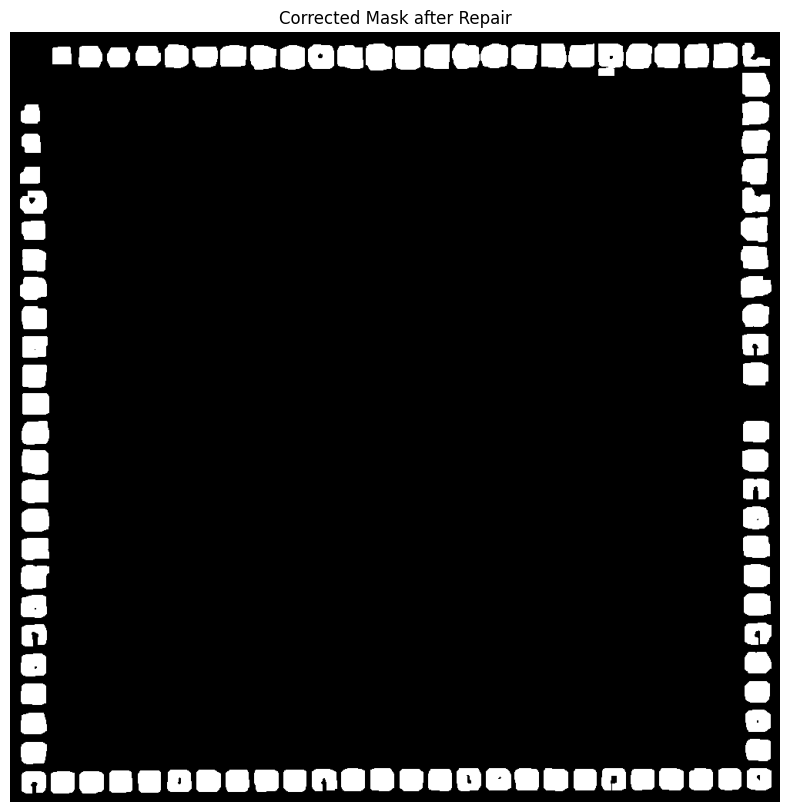

In [6]:
import cv2
import numpy as np

def refine_mask(mask):
    """
    Cleans noise and splits merged pads using 'Pitch' (Pad + Gap) 
    instead of just Pad width to prevent over-splitting.
    """
    # 1. Morphological Open to clean
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # 2. Gather Statistics
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter valid contours (ignore tiny noise for stats)
    valid_contours = [c for c in contours if cv2.contourArea(c) > 30]
    
    if not valid_contours:
        print("No contours found.")
        return opened

    # Get basic rects and centroids
    rects = []
    centers = []
    for c in valid_contours:
        x, y, w, h = cv2.boundingRect(c)
        rects.append((x, y, w, h))
        centers.append([x + w//2, y + h//2])

    # A. Calculate Median Side (Pad Width)
    all_dims = [r[2] for r in rects] + [r[3] for r in rects]
    median_side = np.median(all_dims)
    median_area = np.median([r[2]*r[3] for r in rects])

    # B. Calculate Median Pitch (Pad Center to Neighbor Center) -> The Fix!
    centers = np.array(centers)
    if len(centers) > 1:
        # Brute force distance to find nearest neighbor for every pad
        # (Computes distance from every pad to every other pad)
        diffs = centers[:, np.newaxis, :] - centers[np.newaxis, :, :]
        dists = np.sqrt(np.sum(diffs**2, axis=-1))
        
        # Mask the distance to itself (0.0) with infinity
        np.fill_diagonal(dists, np.inf)
        
        # Get min distance for each pad (distance to nearest neighbor)
        nearest_dists = np.min(dists, axis=1)
        median_pitch = np.median(nearest_dists)
    else:
        # Fallback if only 1 pad exists
        median_pitch = median_side * 1.2 

    print(f"Stats -> Pad Size: {median_side:.1f} | Pitch (Pad+Gap): {median_pitch:.1f}")

    # 3. Process & Split
    final_mask = opened.copy()
    
    for c in valid_contours:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        
        # --- DELETE TOO SMALL ---
        if area < 0.45 * median_area:
            cv2.drawContours(final_mask, [c], -1, 0, -1)
            continue
            
        # --- SPLIT TOO LARGE ---
        # We assume a blob is merged if it's significantly larger than 1 pad
        # We compare against median_side for the trigger, but use PITCH for the count
        if area > 1.5 * median_area:
            
            # Decide split direction
            if w > h: 
                # Horizontal split
                # Use Pitch to calculate count (handles gaps correctly)
                count = int(round(w / median_pitch))
                count = max(2, count)
                
                step = w / count
                for i in range(1, count):
                    split_x = int(x + (i * step))
                    cv2.line(final_mask, (split_x, y), (split_x, y+h), 0, thickness=4)
                    
            else:
                # Vertical split
                count = int(round(h / median_pitch))
                count = max(2, count)
                
                step = h / count
                for i in range(1, count):
                    split_y = int(y + (i * step))
                    cv2.line(final_mask, (x, split_y), (x+w, split_y), 0, thickness=4)

    return final_mask

# --- Usage ---
cleaned_mask = refine_mask(perfect_board)
show_inline(cleaned_mask, "Corrected Mask after Repair")

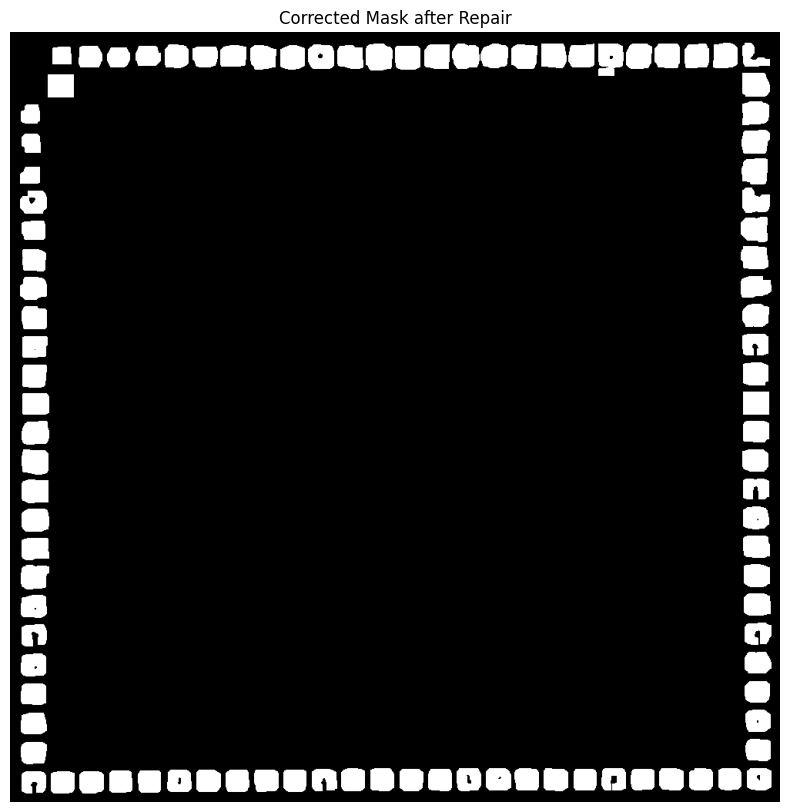

In [7]:
import cv2
import numpy as np

def repair_mask_with_corners(image_path_or_array):
    """
    Detects missing pads in a periodic square mask, including missing corners,
    and fills them in.
    """
    # 1. Load and Preprocess
    if isinstance(image_path_or_array, str):
        img = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
    else:
        img = image_path_or_array

    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    repaired_mask = thresh.copy()
    debug_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    # 2. Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("No contours found.")
        return img

    # 3. Filter and Gather Stats
    pad_rects = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        if area > 50: # Basic noise filter
            pad_rects.append({'x': x, 'y': y, 'w': w, 'h': h, 'cx': x + w//2, 'cy': y + h//2})

    if not pad_rects:
        return img

    median_w = int(np.median([p['w'] for p in pad_rects]))
    median_h = int(np.median([p['h'] for p in pad_rects]))

    # 4. Determine Global Bounds to detect corners
    all_x = [p['cx'] for p in pad_rects]
    all_y = [p['cy'] for p in pad_rects]
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    
    width_tol = (max_x - min_x) * 0.10
    height_tol = (max_y - min_y) * 0.10

    groups = {
        'left':   [], 'right':  [],
        'top':    [], 'bottom': []
    }

    # Group pads
    for p in pad_rects:
        if abs(p['cx'] - min_x) < width_tol: groups['left'].append(p)
        if abs(p['cx'] - max_x) < width_tol: groups['right'].append(p)
        if abs(p['cy'] - min_y) < height_tol: groups['top'].append(p)
        if abs(p['cy'] - max_y) < height_tol: groups['bottom'].append(p)

    # Helper function to draw a pad at (cx, cy)
    def draw_pad(cx, cy):
        tl_x = int(cx - median_w // 2)
        tl_y = int(cy - median_h // 2)
        cv2.rectangle(repaired_mask, (tl_x, tl_y), (tl_x + median_w, tl_y + median_h), 255, -1)
        # Draw green for debug
        cv2.rectangle(debug_vis, (tl_x, tl_y), (tl_x + median_w, tl_y + median_h), (0, 255, 0), -1)

    # 5. Process Each Side
    for side, pads in groups.items():
        if len(pads) < 2: continue

        is_vertical = side in ['left', 'right']
        
        # Sort pads
        # Vertical sides (Left/Right) sorted by Y
        # Horizontal sides (Top/Bottom) sorted by X
        pads.sort(key=lambda k: k['cy'] if is_vertical else k['cx'])

        # Determine axis and bounds
        if is_vertical:
            coords = [p['cy'] for p in pads]
            start_bound = min_y
            end_bound = max_y
            main_axis = 'cy'
            cross_axis = 'cx'
        else:
            coords = [p['cx'] for p in pads]
            start_bound = min_x
            end_bound = max_x
            main_axis = 'cx'
            cross_axis = 'cy'

        # Calculate median step for this side
        diffs = np.diff(coords)
        if len(diffs) == 0: continue
        median_step = np.median(diffs)

        # --- A. Extrapolation (Fix Missing Corners/Ends) ---
        
        # Check Head (Distance from expected start to first pad)
        dist_head = coords[0] - start_bound
        if dist_head > median_step * 0.5: # 0.5 is tolerance
            missing_head = int(round(dist_head / median_step))
            if missing_head > 0:
                print(f"Detected {missing_head} missing corner/end pad(s) at START of {side}.")
                ref_pad = pads[0]
                for m in range(1, missing_head + 1):
                    # Extrapolate backwards
                    shift = m * median_step
                    new_main = ref_pad[main_axis] - shift
                    new_cross = ref_pad[cross_axis]
                    
                    if is_vertical: draw_pad(new_cross, new_main)
                    else:           draw_pad(new_main, new_cross)

        # Check Tail (Distance from last pad to expected end)
        dist_tail = end_bound - coords[-1]
        if dist_tail > median_step * 0.5:
            missing_tail = int(round(dist_tail / median_step))
            if missing_tail > 0:
                print(f"Detected {missing_tail} missing corner/end pad(s) at END of {side}.")
                ref_pad = pads[-1]
                for m in range(1, missing_tail + 1):
                    # Extrapolate forwards
                    shift = m * median_step
                    new_main = ref_pad[main_axis] + shift
                    new_cross = ref_pad[cross_axis]
                    
                    if is_vertical: draw_pad(new_cross, new_main)
                    else:           draw_pad(new_main, new_cross)

        # --- B. Interpolation (Fix Internal Gaps) ---
        for i, step in enumerate(diffs):
            if step > 1.5 * median_step:
                missing_count = int(round(step / median_step) - 1)
                if missing_count > 0:
                    p1 = pads[i]
                    p2 = pads[i+1]
                    for m in range(1, missing_count + 1):
                        fraction = m / (missing_count + 1)
                        new_cx = int(p1['cx'] + (p2['cx'] - p1['cx']) * fraction)
                        new_cy = int(p1['cy'] + (p2['cy'] - p1['cy']) * fraction)
                        draw_pad(new_cx, new_cy)

    return repaired_mask, debug_vis
# --- Usage Example ---
# Assuming you have the image saved as 'mask.png'
result_mask, visual_debug = repair_mask_with_corners(cleaned_mask)
show_inline(result_mask, "Corrected Mask after Repair")

In [8]:
import cv2
import numpy as np

def repair_mask_with_corners(image_path_or_array):
    """
    Detects missing pads in a periodic square mask, including missing corners,
    and fills them in.
    """
    # 1. Load and Preprocess
    if isinstance(image_path_or_array, str):
        img = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
    else:
        img = image_path_or_array

    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    repaired_mask = thresh.copy()
    debug_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    # 2. Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("No contours found.")
        return img

    # 3. Filter and Gather Stats
    pad_rects = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        if area > 50: # Basic noise filter
            pad_rects.append({'x': x, 'y': y, 'w': w, 'h': h, 'cx': x + w//2, 'cy': y + h//2})

    if not pad_rects:
        return img

    median_w = int(np.median([p['w'] for p in pad_rects]))
    median_h = int(np.median([p['h'] for p in pad_rects]))

    # 4. Determine Global Bounds to detect corners
    all_x = [p['cx'] for p in pad_rects]
    all_y = [p['cy'] for p in pad_rects]
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    
    width_tol = (max_x - min_x) * 0.10
    height_tol = (max_y - min_y) * 0.10

    groups = {
        'left':   [], 'right':  [],
        'top':    [], 'bottom': []
    }

    # Group pads
    for p in pad_rects:
        if abs(p['cx'] - min_x) < width_tol: groups['left'].append(p)
        if abs(p['cx'] - max_x) < width_tol: groups['right'].append(p)
        if abs(p['cy'] - min_y) < height_tol: groups['top'].append(p)
        if abs(p['cy'] - max_y) < height_tol: groups['bottom'].append(p)

    # Helper function to draw a pad at (cx, cy)
    def draw_pad(cx, cy):
        tl_x = int(cx - median_w // 2)
        tl_y = int(cy - median_h // 2)
        cv2.rectangle(repaired_mask, (tl_x, tl_y), (tl_x + median_w, tl_y + median_h), 255, -1)
        # Draw green for debug
        cv2.rectangle(debug_vis, (tl_x, tl_y), (tl_x + median_w, tl_y + median_h), (0, 255, 0), -1)

    # 5. Process Each Side
    for side, pads in groups.items():
        if len(pads) < 2: continue

        is_vertical = side in ['left', 'right']
        
        # Sort pads
        # Vertical sides (Left/Right) sorted by Y
        # Horizontal sides (Top/Bottom) sorted by X
        pads.sort(key=lambda k: k['cy'] if is_vertical else k['cx'])

        # Determine axis and bounds
        if is_vertical:
            coords = [p['cy'] for p in pads]
            start_bound = min_y
            end_bound = max_y
            main_axis = 'cy'
            cross_axis = 'cx'
        else:
            coords = [p['cx'] for p in pads]
            start_bound = min_x
            end_bound = max_x
            main_axis = 'cx'
            cross_axis = 'cy'

        # Calculate median step for this side
        diffs = np.diff(coords)
        if len(diffs) == 0: continue
        median_step = np.median(diffs)

        # --- A. Extrapolation (Fix Missing Corners/Ends) ---
        
        # Check Head (Distance from expected start to first pad)
        dist_head = coords[0] - start_bound
        if dist_head > median_step * 0.5: # 0.5 is tolerance
            missing_head = int(round(dist_head / median_step))
            if missing_head > 0:
                print(f"Detected {missing_head} missing corner/end pad(s) at START of {side}.")
                ref_pad = pads[0]
                for m in range(1, missing_head + 1):
                    # Extrapolate backwards
                    shift = m * median_step
                    new_main = ref_pad[main_axis] - shift
                    new_cross = ref_pad[cross_axis]
                    
                    if is_vertical: draw_pad(new_cross, new_main)
                    else:           draw_pad(new_main, new_cross)

        # Check Tail (Distance from last pad to expected end)
        dist_tail = end_bound - coords[-1]
        if dist_tail > median_step * 0.5:
            missing_tail = int(round(dist_tail / median_step))
            if missing_tail > 0:
                print(f"Detected {missing_tail} missing corner/end pad(s) at END of {side}.")
                ref_pad = pads[-1]
                for m in range(1, missing_tail + 1):
                    # Extrapolate forwards
                    shift = m * median_step
                    new_main = ref_pad[main_axis] + shift
                    new_cross = ref_pad[cross_axis]
                    
                    if is_vertical: draw_pad(new_cross, new_main)
                    else:           draw_pad(new_main, new_cross)

        # --- B. Interpolation (Fix Internal Gaps) ---
        for i, step in enumerate(diffs):
            if step > 1.5 * median_step:
                missing_count = int(round(step / median_step) - 1)
                if missing_count > 0:
                    p1 = pads[i]
                    p2 = pads[i+1]
                    for m in range(1, missing_count + 1):
                        fraction = m / (missing_count + 1)
                        new_cx = int(p1['cx'] + (p2['cx'] - p1['cx']) * fraction)
                        new_cy = int(p1['cy'] + (p2['cy'] - p1['cy']) * fraction)
                        draw_pad(new_cx, new_cy)

    return repaired_mask, debug_vis

In [9]:
import cv2
import numpy as np
import math

def detect_local_anomalies_robust(original_img, pad_data, period=5, neighbor_count=3, sensitivity=40):
    """
    Detects anomalies using Euclidean distance in HSV space, ensuring 
    black/white objects (Value differences) are detected just as well as 
    colored objects (Hue/Saturation differences).
    """
    vis = original_img.copy()
    
    # 1. Compute Color Stats
    for p in pad_data:
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        roi = original_img[y+2:y+h-2, x+2:x+w-2]
        if roi.size > 0:
            mean_bgr = np.mean(roi, axis=(0,1))
            p['hsv'] = cv2.cvtColor(np.uint8([[mean_bgr]]), cv2.COLOR_BGR2HSV)[0][0]
        else:
            p['hsv'] = np.array([0, 0, 0])

    # 2. Split into Clusters
    cluster_yellow = [p for i, p in enumerate(pad_data) if i % period == 0]
    cluster_orange = [p for i, p in enumerate(pad_data) if i % period != 0]

    # 3. Local Check Function
    def check_cluster(cluster_list, color_name, draw_color):
        count = len(cluster_list)
        if count < neighbor_count * 2 + 1: return

        for i, pad in enumerate(cluster_list):
            current_color = pad['hsv'].astype(float)
            
            # Collect neighbors
            neighbors_hsv = []
            for offset in range(1, neighbor_count + 1):
                prev_idx = (i - offset) % count
                next_idx = (i + offset) % count
                neighbors_hsv.append(cluster_list[prev_idx]['hsv'].astype(float))
                neighbors_hsv.append(cluster_list[next_idx]['hsv'].astype(float))
            
            local_mean = np.mean(neighbors_hsv, axis=0)
            
            # Calculate Differences
            diff_h = abs(current_color[0] - local_mean[0])
            diff_s = abs(current_color[1] - local_mean[1])
            diff_v = abs(current_color[2] - local_mean[2])
            
            # Hue wrap-around fix
            diff_h = min(diff_h, 180 - diff_h)

            # --- THE FIX: Euclidean Distance ---
            # Instead of weighted sums, we calculate the straight-line distance
            # in 3D HSV space. This gives equal importance to a change in 
            # Brightness (Value) as it does to a change in Color (Hue/Sat).
            deviation_score = math.sqrt(diff_h**2 + diff_s**2 + diff_v**2)
            
            pad['deviation'] = deviation_score

            # Visualization
            x, y, w, h = pad['x'], pad['y'], pad['w'], pad['h']
            cv2.rectangle(vis, (x, y), (x+w, y+h), draw_color, 1)

            if deviation_score > sensitivity:
                # Thick Red Box for Anomaly
                cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 3)
                # Label score
                cv2.putText(vis, f"{int(deviation_score)}", (x, y-5), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
                print(f"Anomaly in {color_name} at index {i} | Score: {deviation_score:.1f}")

    # 4. Run checks
    check_cluster(cluster_yellow, "Yellow", (0, 255, 255))
    check_cluster(cluster_orange, "Orange", (0, 165, 255))

    return vis

# --- Usage ---
# Try starting with sensitivity=40 with this new formula. Tune up/down as needed.
result_vis = detect_local_anomalies_robust(map, pad_data, period=5, neighbor_count=3, sensitivity=37)
cv2.imwrite('final_anomalies_robust.png', result_vis)
show_inline(result_vis)

NameError: name 'pad_data' is not defined

In [ ]:
import cv2
import numpy as np

def extract_inner_map(original_img, pad_data):
    """
    Uses the detected grid pads to find the inner bounding box of the map
    and performs a perspective transform to extract a flat, top-down view.
    """
    if not pad_data:
        print("No pad data provided.")
        return original_img

    # 1. Identify the 4 Corner Pads based on geometric extremes
    # (This works even if the board is rotated)
    # TL: Min (x + y), TR: Max (x - y), BR: Max (x + y), BL: Min (x - y)
    
    pad_tl = min(pad_data, key=lambda p: p['x'] + p['y'])
    pad_tr = max(pad_data, key=lambda p: p['x'] - p['y'])
    pad_br = max(pad_data, key=lambda p: p['x'] + p['y'])
    pad_bl = min(pad_data, key=lambda p: p['x'] - p['y'])

    # 2. Define the Inner Corners (The points touching the map)
    # Note: boundingRect is axis-aligned. 
    # TL Pad -> Use its Bottom-Right corner (x+w, y+h)
    src_tl = [pad_tl['x'] + pad_tl['w'], pad_tl['y'] + pad_tl['h']]
    
    # TR Pad -> Use its Bottom-Left corner (x, y+h)
    src_tr = [pad_tr['x'], pad_tr['y'] + pad_tr['h']]
    
    # BR Pad -> Use its Top-Left corner (x, y)
    src_br = [pad_br['x'], pad_br['y']]
    
    # BL Pad -> Use its Top-Right corner (x+w, y)
    src_bl = [pad_bl['x'] + pad_bl['w'], pad_bl['y']]

    src_pts = np.float32([src_tl, src_tr, src_br, src_bl])

    # 3. Calculate Target Dimensions
    # We use the maximum width/height found to keep the aspect ratio correct
    width_top = np.linalg.norm(src_pts[1] - src_pts[0])
    width_btm = np.linalg.norm(src_pts[2] - src_pts[3])
    max_width = int(max(width_top, width_btm))

    height_lft = np.linalg.norm(src_pts[3] - src_pts[0])
    height_rgt = np.linalg.norm(src_pts[2] - src_pts[1])
    max_height = int(max(height_lft, height_rgt))

    # 4. Define Destination Points (A perfect rectangle)
    dst_pts = np.float32([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ])

    # 5. Perform the Warp
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_map = cv2.warpPerspective(original_img, M, (max_width, max_height))

    # Optional: Draw debug lines on original to show what we cropped
    debug_img = original_img.copy()
    cv2.polylines(debug_img, [np.int32(src_pts)], isClosed=True, color=(0, 255, 0), thickness=3)

    return warped_map, debug_img

# --- Usage Example ---
# Assuming 'score_track_img' is your main image and 'pad_data' is from the previous step
final_map, crop_debug = extract_inner_map(map, pad_data)

# Show/Save
cv2.imwrite('final_inner_map.png', final_map)
# show_inline(final_map, "Extracted Inner Map")
# show_inline(crop_debug, "Crop Area Visualization")

True